In [1]:
import pandas as pd
import numpy as np 

from copy import copy
from collections import Counter, defaultdict
import ast

import matplotlib.pyplot as plt 
from matplotlib.collections import LineCollection
from matplotlib import cm
from shapely.geometry import Polygon

from scipy.spatial import Delaunay,Voronoi

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

from colormath.color_diff import delta_e_cie2000
from colormath.color_objects import LabColor, sRGBColor
from colormath.color_conversions import convert_color

from igraph import *

from tqdm.notebook import trange, tqdm

import importlib
import TissueGraph as tg

from MERFISH_Objects.FISHData import *

import scanpy as sc

%load_ext line_profiler

In [2]:
# make sure to start the ipcluster: !ipcluster start -n 16 (or as many cores as you want)
from ipyparallel import Client
rc = Client()

In [3]:
base_path = '/bigstore/Images2021/gaby/dredFISH/DPNMF_PolyA_2021Nov19/'
dataset = 'DPNMF_PolyA_2021Nov19'
fishdata = FISHData(os.path.join(base_path,'fishdata'))
data = fishdata.load_data('h5ad',dataset=dataset)
data.obs_names_make_unique()

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [4]:
data.X = data.layers['total_vectors']
data = data[np.isnan(data.X.max(1))==False]

data.X = data.X/data.obs['total_signal'][:,None]
data.X = data.X - np.array([np.percentile(data.X[:,i],25) for i in range(data.X.shape[1])])
data.X = data.X / np.array([np.percentile(data.X[:,i],75) for i in range(data.X.shape[1])])
data.X = normalize(data.X)

XY = np.asarray([data.obs['stage_y'], data.obs['stage_x']])
XY = np.transpose(XY)
data.obsm['stage'] = XY


/tmp/ipykernel_1570450/2357336674.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  data.X = data.X/data.obs['total_signal'][:,None]


In [5]:
TG = tg.TissueGraph()
TG.BuildSpatialGraph(XY)

In [6]:
sc.pp.neighbors(data, n_neighbors=10, n_pcs=0)


Large optimization using ipyparallel over possible resolution parameters

In [7]:
dview = rc[:]
@dview.parallel(block = True)
def Leiden(res):
    scanpy.tl.leiden(data,resolution=res)
    cls = data.obs['leiden']
    return(cls)

with dview.sync_imports():  
    import scanpy

datadict = {"data" : data}
dview.push(datadict)

ResVec = np.logspace(-1,1.5,48)
entropy = np.empty(len(ResVec))
permentropy =  np.empty(len(ResVec))
Sz = np.empty(len(ResVec))
results = Leiden(ResVec)

Nzones = np.empty(len(ResVec))
permNzones = np.zeros(len(ResVec))

for j in range(len(results)):
    cls = np.asarray(results[j])
    Sz[j] = np.max(cls.astype(np.uint16)) 
    TypeVec = np.asarray(results[j])
    ZG = TG.ContractGraph(TypeVec)
    Nzones[j]=ZG.G.vcount()
    entropy[j] = ZG.CondEntropy()
    permZG = TG.ContractGraph(np.random.permutation(TypeVec))
    permNzones[j] = permZG.G.vcount()
    permentropy[j] = permZG.CondEntropy()

importing scanpy on engine(s)


In [112]:
%time
from scipy.optimize import minimize_scalar
import scanpy as sc
def OptLeiden(res):
    sc.tl.leiden(data,resolution=res)
    TypeVec = np.asarray(data.obs['leiden'])
    ZG = TG.ContractGraph(TypeVec)
    entropy = ZG.CondEntropy()
    return(-entropy)

res = minimize_scalar(OptLeiden, bracket = (0.1,30), method='brent',options={'xtol': 1e-2, 'disp': True})
res['fun']
res['x']

CPU times: user 8 µs, sys: 1e+03 ns, total: 9 µs
Wall time: 17.6 µs


/tmp/ipykernel_1570450/2591935147.py:11: OptimizeWarning: Unknown solver options: disp
  res = minimize_scalar(OptLeiden, bracket = (0.1,30), method='brent',options={'xtol': 1e-2, 'disp': True})


In [114]:
res['nfev']

13

Opt Ntypes: 96.0
Opt Ntypes (for perm): 9.0


array([12.46419664, 12.4540845 , 12.44942804, 12.47124385, 12.46354546,
       12.4857627 , 12.37727305, 12.51314959, 12.58301202, 12.45422912,
       12.37047875, 12.26009563, 12.24283065, 12.1840549 ])

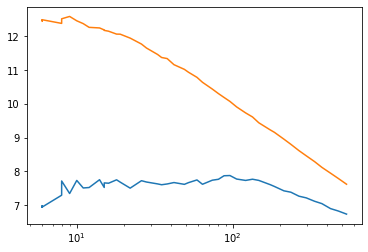

In [15]:
plt.semilogx(Sz,entropy)
plt.semilogx(Sz,permentropy)
print(f"Opt Ntypes: {Sz[np.argmax(entropy)]}")
print(f"Opt Ntypes (for perm): {Sz[np.argmax(permentropy)]}")
permentropy[0:14]

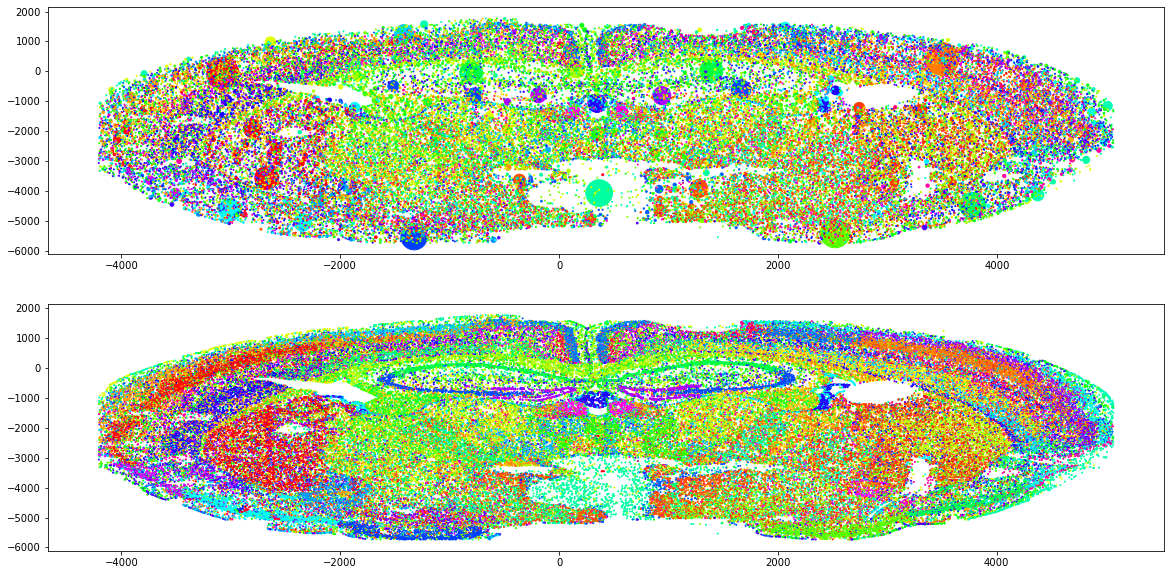

In [10]:
typ = np.asarray(results[np.argmax(entropy)])
ZG = TG.ContractGraph(typ)
fig, axs = plt.subplots(2,figsize=(20,10))
zsz = np.asarray(ZG.G.vs["Size"])
axs[0].scatter(x=ZG.X,y=ZG.Y,c=np.asarray(ZG.Type).astype(np.uint16),s=zsz,cmap='hsv')
axs[1].scatter(x=TG.X,y=TG.Y,c=typ.astype(np.uint16),s=1,cmap='hsv')


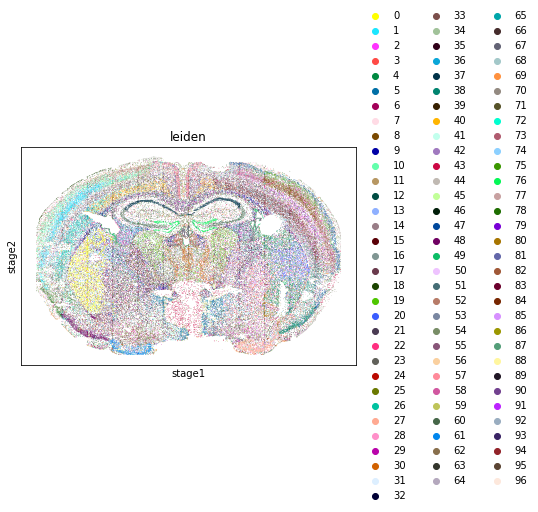

In [11]:
sc.tl.leiden(data,resolution=ResVec[np.argmax(entropy)])
sc.pl.embedding(data,'stage', color=['leiden'])

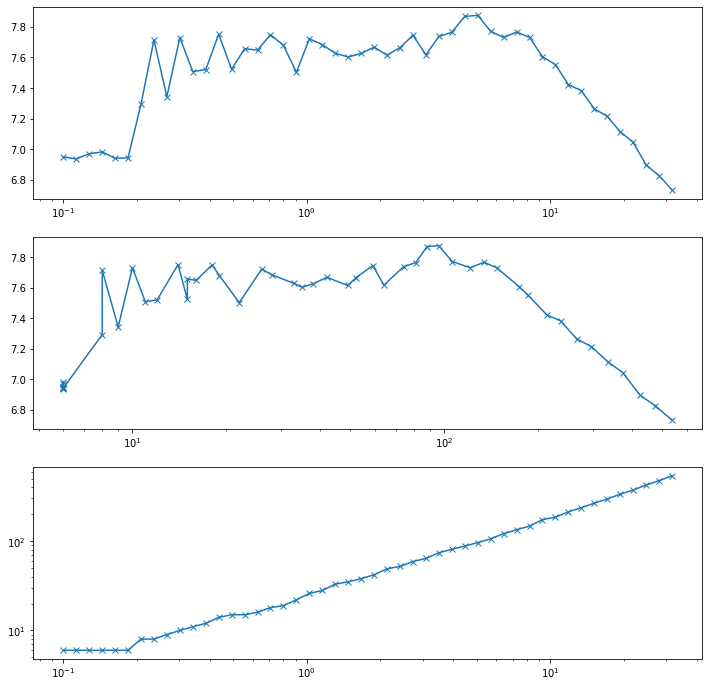

In [17]:
fig, axs = plt.subplots(3,figsize=(12,12))

axs[0].plot(ResVec,entropy,'x-')
axs[0].set_xscale('log')


axs[1].plot(Sz,entropy,'x-')
axs[1].set_xscale('log')

axs[2].plot(ResVec,Sz,'x-')
axs[2].set_xscale('log')
axs[2].set_yscale('log')



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96


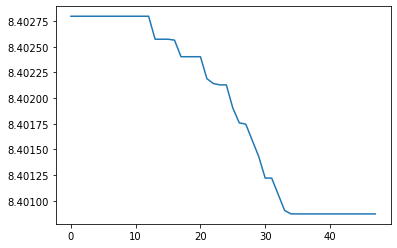

In [61]:
# see if breaking clusters helps
cls = np.asarray(results[np.argmax(entropy)])
ResVec = np.logspace(-1,1.5,48)

dash = np.array((1,),dtype='object')
dash[0]='_' 
unqcls = np.unique(cls)
lvl2=list()
ent_lvl2=np.empty((len(unqcls),len(ResVec)))
ent_best = max(entropy)
OptResVec = np.empty(len(unqcls))

for i in range(len(unqcls)):
    print(i)
    newcls = cls.copy()
    smalldata = data[cls==unqcls[i]]
        
    # key parallel optimization of all ResVec values
    sc.pp.neighbors(smalldata, n_neighbors=10, n_pcs=0)
    posslvl2=list()
    for j in range(len(ResVec)):
        sc.tl.leiden(smalldata,resolution=ResVec[j])
        posslvl2.append(np.asarray(smalldata.obs['leiden']))
        newcls[cls==unqcls[i]] = cls[cls==unqcls[i]]+dash+posslvl2[j]
        ent_lvl2[i,j] = TG.ContractGraph(newcls).CondEntropy()
    
    ix_mx = np.argmax(ent_lvl2[i,:])
    OptResVec[i]=ResVec[ix_mx]    
    lvl2.append(posslvl2[ix_mx])
    newcls[cls==unqcls[i]] = cls[cls==unqcls[i]]+dash+lvl2[i]
       
    if ent_lvl2[i,ix_mx]>ent_best: 
        cls = newcls.copy()
        ent_best=ent_lvl2[i,ix_mx]

plt.plot(np.amax(ent_lvl2,axis=0))

172

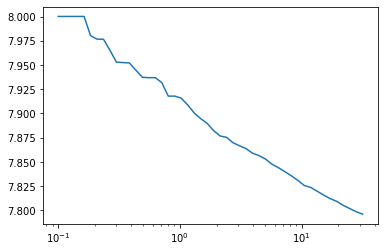

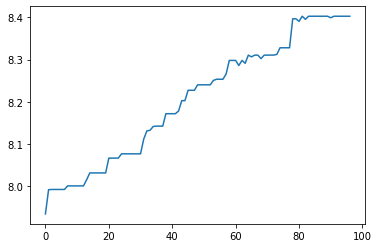

In [80]:
plt.semilogx(ResVec,ent_lvl2[8,:])
plt.figure()
plt.plot(np.amax(ent_lvl2,axis=1))
len(list(Counter(newcls)))

In [86]:
Counter(newcls)
Counter(np.asarray(ZG.Type).astype(np.uint16))

Counter({78: 210,
         63: 711,
         24: 1091,
         70: 669,
         62: 767,
         480: 113,
         33: 939,
         85: 419,
         64: 720,
         59: 520,
         34: 735,
         69: 479,
         26: 1137,
         80: 586,
         31: 1031,
         11: 1592,
         56: 642,
         28: 883,
         49: 535,
         42: 768,
         381: 85,
         2: 1846,
         51: 690,
         44: 484,
         90: 199,
         670: 99,
         100: 406,
         521: 241,
         272: 201,
         13: 1481,
         0: 374,
         570: 107,
         46: 805,
         3: 1477,
         672: 77,
         470: 176,
         72: 391,
         35: 1034,
         520: 302,
         88: 319,
         101: 296,
         87: 176,
         383: 46,
         10: 307,
         12: 1031,
         17: 1081,
         482: 74,
         74: 396,
         14: 1292,
         68: 273,
         60: 1169,
         1: 314,
         7: 1300,
         22: 1087,
         32

(array([ 880.,  760.,  615., 1070.,  517., 1585., 1564., 1517., 1476.,
         836.,  629., 1463., 1458., 1444., 1430.,  701.,  540.,  413.,
         229., 1881.,  880.,  495.,   11.,  734.,  629., 1325.,  681.,
         625., 1295., 1284., 1277.,  427.,  341.,  298.,  200., 1263.,
        1237., 1813.,  767.,  463., 1229., 1211., 1153., 1151., 1150.,
        1132.,  231.,  192.,  190.,  189.,  174.,  150.,  323.,  298.,
         241.,  187.,   74.,  783.,  336.,  484.,  378.,  246., 1090.,
        1090.,  280.,  256.,  232.,  206.,   93., 1066., 1035., 1033.,
         517.,  510.,  452.,  247.,  157.,  150.,   19., 1022.,  634.,
         604.,  539., 1015., 1012.,  524.,  468.,  946.,  926.,  921.,
         913.,  313.,  237.,  220.,  139.,  446.,  443.,  853., 1039.,
         565.,  170.,  109.,   88.,   48.,   35.,   85.,   85.,   81.,
          80.,   74.,   58.,   52.,   49.,  193.,  175.,  166.,  153.,
         145.,  823.,  813.,  806.,  803.,  802.,  165.,  144.,  137.,
      

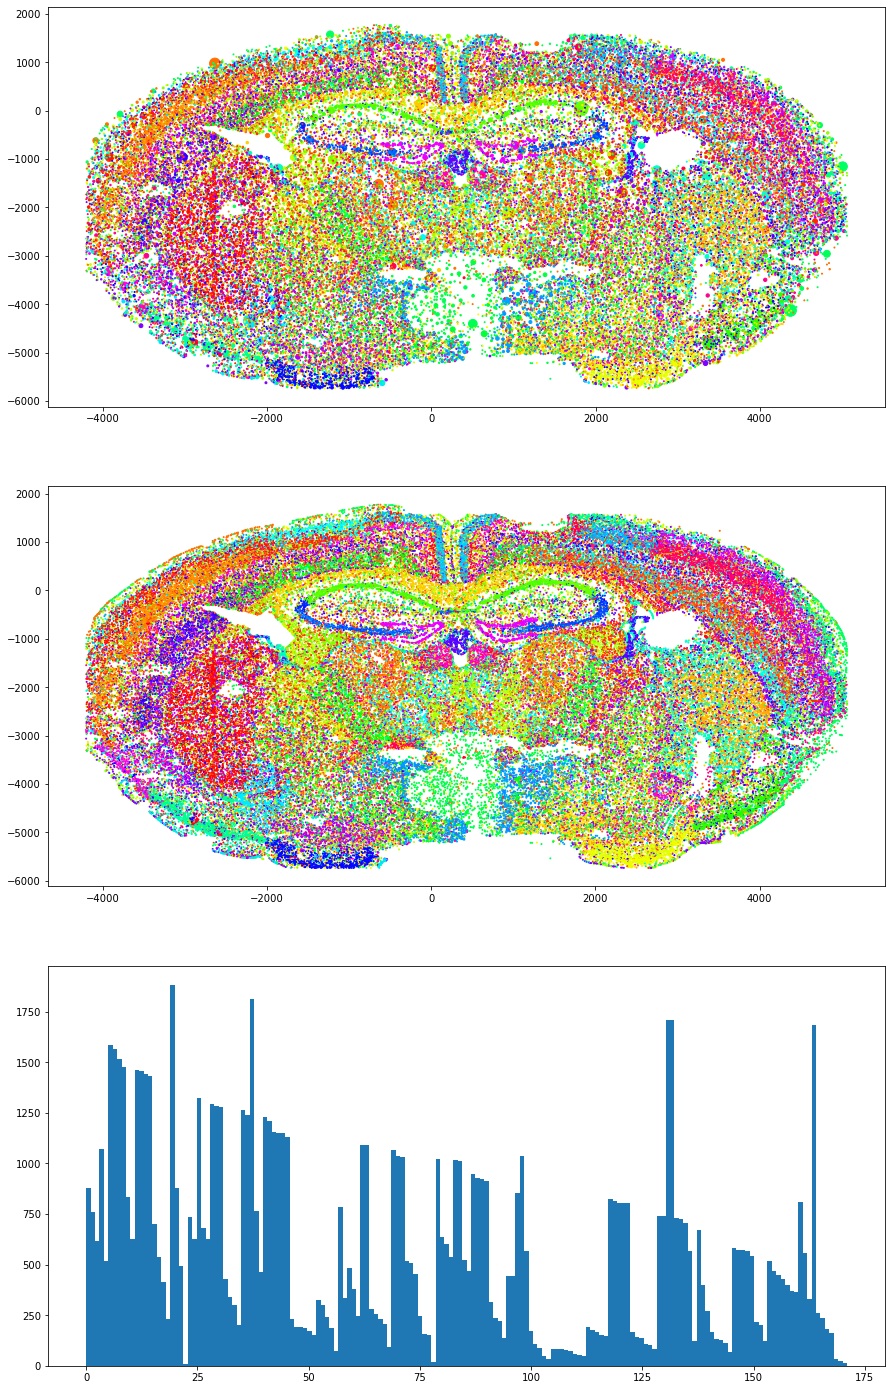

In [96]:
unq,typ = np.unique(newcls,return_inverse = True)
ZG = TG.ContractGraph(typ)
fig, axs = plt.subplots(3,figsize=(15,25))
zsz = np.asarray(ZG.G.vs["Size"])
axs[0].scatter(x=ZG.X,y=ZG.Y,c=np.asarray(ZG.Type).astype(np.uint16),s=zsz,cmap='hsv')
axs[1].scatter(x=TG.X,y=TG.Y,c=typ.astype(np.uint16),s=1,cmap='hsv')
axs[2].hist(typ,bins=172)
# plt.savefig('optimal_brainmaps.png')

In [97]:
# Code below didn't work, I rewrote it without ipyparallel in cell above this.  
# see if breaking clusters helps
# cls = np.asarray(results[np.argmax(entropy)])

# ResVec = np.logspace(-1,1.5,48)

# # set up funciton to optimize in parllel using ipyparallel
# dview = rc[:]
# @dview.parallel(block = True)
# def LeidenOnSubset(res):
#     scanpy.pp.neighbors(smalldata, n_neighbors=10, n_pcs=0)
#     scanpy.tl.leiden(smalldata,resolution=res)
#     cls = data.obs['leiden']
#     return(cls)

# # get scanpy to engines
# with dview.sync_imports():  
#     import scanpy

# dash = np.array((1,),dtype='object')
# dash[0]='_' 
# unqcls = np.unique(cls)
# lvl2=list()
# ent_lvl2=np.empty(len(unqcls))
# ent_best = max(entropy)
# OptResVec = np.zeros(len(unqcls))
# for i in range(len(unqcls)):
#     print(i)
#     newcls = cls.copy()
#     smalldata = data[cls==unqcls[i]]
#     datadict = {"smalldata" : smalldata}
#     dview.push(datadict)
    
#     # key parallel optimization of all ResVec values
#     smlresults = LeidenOnSubset(ResVec)
#     smlentropy = [TG.ContractGraph(np.asarray(rs)).CondEntropy() for rs in smlresults]
    
#     ent_lvl2[i] = max(smlentropy)
#     optRes = ResVec[np.argmax(smlentropy)]
#     OptResVec[i]=optRes
    
#     sc.tl.leiden(smalldata,resolution=optRes)
#     lvl2.append(np.asarray(smalldata.obs['leiden']))
#     newcls[cls==unqcls[i]] = cls[cls==unqcls[i]]+dash+lvl2[i]
    
#     if ent_lvl2[i]>ent_best: 
#         cls = newcls.copy()
#         ent_best=ent_lvl2[i]